# Star Trek Uniform Classifier - CNN

* Collect images of Star Trek uniforms
    * Red, Blue, Gold

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.layers import Conv2D # to add convolutional layers
from keras.layers import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
import os
from pathlib import Path
from PIL import Image

# Load data

In [2]:
# define data path and categories
data_dir = Path('rawData')
categories = ['commandRed', 'scienceBlue', 'operationGold']

In [2]:
# function to handle images
def clean_and_verify_data(base_path, folder_list):

    # iterate through categires
    for category in folder_list:
        path = base_path / category
        print(f"==== Checking for: {category} ====")

        files = list(path.glob('*'))
        for file_path in files:
            # remove everything except jpg, jpeg and png
            if file_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                print(f"Revoming: {file_path.name}")
                file_path.unlink()
                continue

            try:
                # try open img to check for corruption
                with Image.open(file_path) as img:
                    img.verify() # verify whether its img

                # convert to RBG in case more channels
                with Image.open(file_path) as img:
                    img = img.convert('RGB')
                    img = img.resize((128, 128)) # resize img 
                    img.save(file_path) # overwrite !!

            except (IOError, SyntaxError) as e:
                print(f"Deleting file: {file_path.name}")
                file_path.unlink()


In [3]:
clean_and_verify_data(data_dir, categories)

NameError: name 'data_dir' is not defined

# Normalize data and split

In [3]:
from keras import layers
# constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# load and split
train_ds = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2, # 20% for testing
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2, # 20% for validation
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# save classes name for debug
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# normalize
normalization_layer = layers.Rescaling(1./255)

# apply to dataset
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 787 files belonging to 3 classes.
Using 630 files for training.
Found 787 files belonging to 3 classes.
Using 157 files for validation.
Classes found: ['commandRed', 'operationGold', 'scienceBlue']


# Veryfing if data is GOOD

## Visual verification

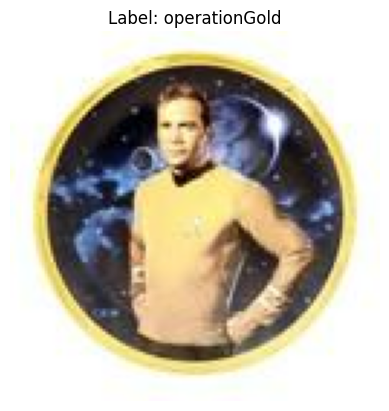

Max pixel value: 1.0
Min pixel value: 0.0


2026-02-15 17:05:31.825035: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# take one batch from ds
for images, labels in train_ds.take(1):
    # images is a tensor of shape (32, 128, 128, 3)
    # labels is a tensor of shape (32, 3)
    
    first_image = images[0].numpy()
    first_label = labels[0].numpy()
    
    plt.imshow(first_image)
    plt.title(f"Label: {class_names[np.argmax(first_label)]}")
    plt.axis('off')
    plt.show()

    # print pixel range (max should be 1 and min should be 0)
    print(f"Max pixel value: {np.max(first_image)}")
    print(f"Min pixel value: {np.min(first_image)}")

## Shape verification

In [5]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}") # expect (32, 128, 128, 3), batch size, height, widht, channel numb RGB
    print(f"Label batch shape: {labels.shape}") # expect (32, 3)
    break

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 3)


## Class balance verification - after cleaning

In [6]:
for category in class_names:
    path = f'rawData/{category}'
    print(f"{category}: {len(os.listdir(path))} images")

commandRed: 293 images
operationGold: 217 images
scienceBlue: 280 images


* operationGold is a bit smaller. **NEED TO AUGMENTATION** 

## Normalization check

In [7]:
for images, labels in train_ds.take(1):
    print(f"Data type: {images.dtype}") 
    print(f"First pixel value: {images[0, 0, 0, 0].numpy()}")
# expect float32

Data type: <dtype: 'float32'>
First pixel value: 0.4549019932746887


2026-02-15 17:05:39.007858: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Building Convolutional Neural Network

In [8]:
# building the model

# augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def star_trek_cnn_model():
    '''
    input
    3 Conv2D / Maxpooling layers; relu
    flatten
    dense; relu
    regularization
    output, dense; softmax to probabilities
    '''
    model = keras.Sequential([
        # input
        layers.Input(shape=(128, 128, 3)),
        data_augmentation,

        # first layer, edges
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # second layer, shapes
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # third layer, complex patterns
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # output layer
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

In [9]:
# init and run model
custom_model = star_trek_cnn_model()
custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training Model

In [10]:
history = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=1
)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5238 - loss: 1.0149 - val_accuracy: 0.7134 - val_loss: 0.8685
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.7381 - loss: 0.7393 - val_accuracy: 0.7834 - val_loss: 0.5960
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7857 - loss: 0.5602 - val_accuracy: 0.8025 - val_loss: 0.5523
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8127 - loss: 0.4932 - val_accuracy: 0.8599 - val_loss: 0.4352
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8270 - loss: 0.4813 - val_accuracy: 0.8726 - val_loss: 0.4086
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8476 - loss: 0.4312 - val_accuracy: 0.8917 - val_loss: 0.3722
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8698 - loss: 0.3956 - val_accuracy: 0.9045 - val_loss: 0.3612
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8460 - loss: 0.4214 - val_accuracy: 0.

In [11]:
scores = custom_model.evaluate(val_ds, verbose=0)
print(f"Test Accuracy: {scores[1]:.4f}")
print(f"Test Loss: {scores[0]:.4f}")

Test Accuracy: 0.8981
Test Loss: 0.3345


## Confusion matrix x Loss curve graph

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    # iterate through dataset
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        
        # handle ondehotencode and sparselabelss
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            y_true.extend(np.argmax(labels, axis=1))
        else:
            y_true.extend(labels.numpy())
            
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # conf matrx
    cm = confusion_matrix(y_true, y_pred)
    
    # plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix: Model Performance Evaluation', fontsize=14)
    plt.show()

    # scientific matrics
    print("\n--- CLASSIFICATION REPORT ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

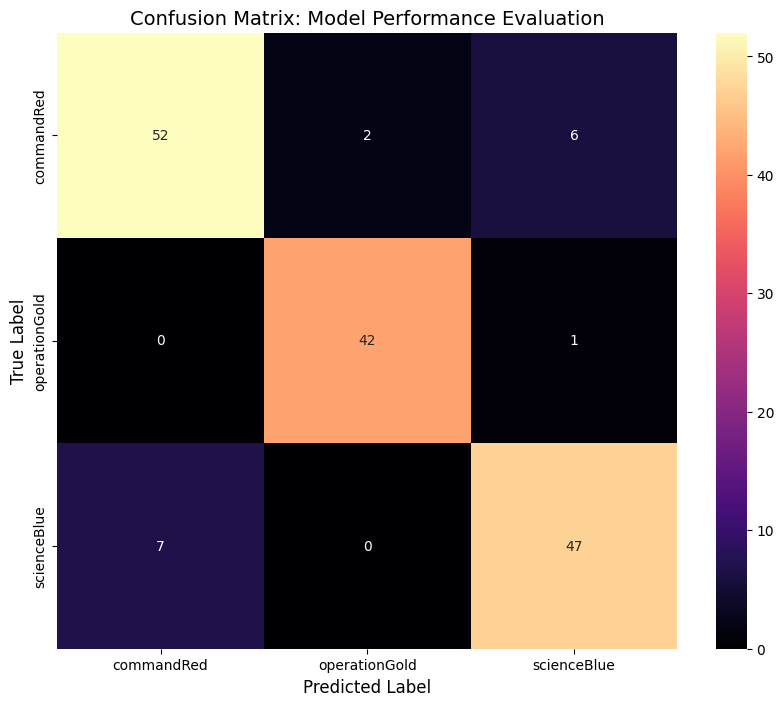


--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

   commandRed       0.88      0.87      0.87        60
operationGold       0.95      0.98      0.97        43
  scienceBlue       0.87      0.87      0.87        54

     accuracy                           0.90       157
    macro avg       0.90      0.90      0.90       157
 weighted avg       0.90      0.90      0.90       157



In [14]:
plot_confusion_matrix(custom_model, val_ds, class_names)

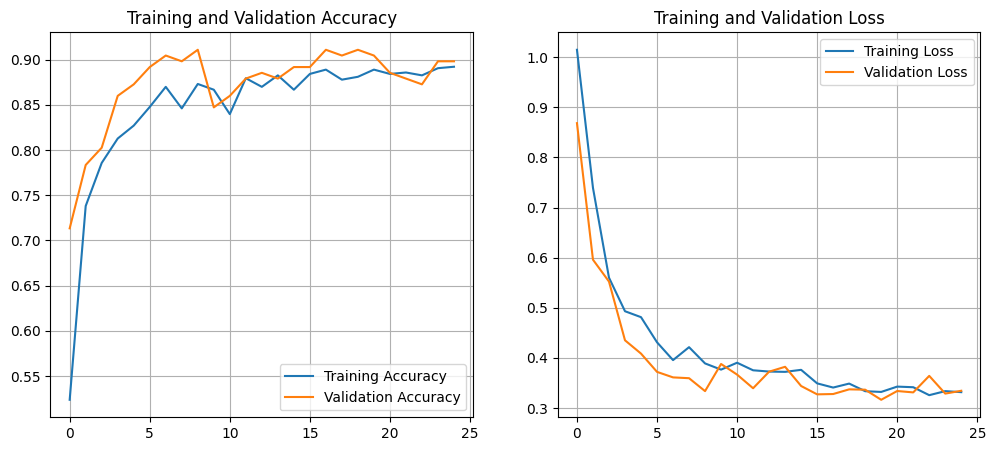

In [15]:
plot_history(history)

# Using a pretrained Model

In [16]:
local_weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'

## Trying MobileNetV2

In [17]:
# transfer learning
base_model = keras.applications.MobileNetV2(
    weights=local_weights_path,
    input_shape=(128, 128, 3),
    include_top=False
)

# freeze the base model
base_model.trainable = False

mobilenet_model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(), # flatten 3D data into 1D
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') 
])

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# train again
history_transfer = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.3460 - loss: 1.4003 - val_accuracy: 0.5287 - val_loss: 0.9761
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5571 - loss: 0.9348 - val_accuracy: 0.6242 - val_loss: 0.7627
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.6921 - loss: 0.7035 - val_accuracy: 0.7070 - val_loss: 0.7024
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7270 - loss: 0.6265 - val_accuracy: 0.7516 - val_loss: 0.6417
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7587 - loss: 0.5799 - val_accuracy: 0.7580 - val_loss: 0.6373
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7762 - loss: 0.5508 - val_accuracy: 0.7452 - val_loss: 0.6277
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8127 - loss: 0.4949 - val_accuracy: 0.7898 - val_loss: 0.5903
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.8143 - loss: 0.4649 - val_accuracy: 0.

* worse than model built from scratch
    * need to unfreeze small bit of pretrained model

In [19]:
# unfreeze base model
base_model.trainable = True

# print(f"Number of layers in base model: {len(base_model.layers)}")
# base model has 154 layers

fine_tune_at = 130 # freeze everything except the last 20 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# recompile // low learning rate
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
fine_tune_epochs = 15
total_epochs = 20 + fine_tune_epochs

history_fine_tune = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1], # start from left off
    verbose=1
)

Epoch 20/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.7794 - loss: 0.5020 - val_accuracy: 0.7834 - val_loss: 0.6142
Epoch 21/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8048 - loss: 0.4883 - val_accuracy: 0.7707 - val_loss: 0.6229
Epoch 22/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.8365 - loss: 0.4197 - val_accuracy: 0.7707 - val_loss: 0.6228
Epoch 23/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.8524 - loss: 0.4222 - val_accuracy: 0.7707 - val_loss: 0.6256
Epoch 24/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8508 - loss: 0.3847 - val_accuracy: 0.7580 - val_loss: 0.6322
Epoch 25/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8460 - loss: 0.3762 - val_accuracy: 0.7452 - val_loss: 0.6454
Epoch 26/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8667 - loss: 0.3667 - val_accuracy: 0.7389 - val_loss: 0.6594
Epoch 27/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8730 - loss: 0.3087 - val_accu

* Accuracy 90%
* Validation accuracy 75%
* overfitting!

* Model is memorizing = overfitting. Training loss decrease while Validation loss increases
* "commandRed" class precision is 0.53
* scienceBlue f1-score is 0.61
* the model guessed commandRed for 39 instances of that actually were scienceBlue
-----
* increase dropout
* L2 regularization

In [21]:
from keras import regularizers
# make the images change to avoid memorizing
data_augmentation.add(layers.RandomContrast(0.2))

# update final layers
mobilenet_model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [22]:
# re compile
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stop callback. If val loss do not 
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Red: 410, Gold: 278, Blue: 396
total = 410 + 278 + 396
class_weight = {
    0: (1 / 410) * (total / 3.0), # red
    1: (1 / 278) * (total / 3.0), # gold
    2: (1 / 396) * (total / 3.0)  # blue
}

# fit with updated callback and weight
history_final = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    class_weight=class_weight, 
    callbacks=[early_stop],    
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.3413 - loss: 3.7860 - val_accuracy: 0.3121 - val_loss: 3.7296
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3603 - loss: 3.6887 - val_accuracy: 0.3439 - val_loss: 3.6162
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.4000 - loss: 3.6157 - val_accuracy: 0.4204 - val_loss: 3.5265
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.4556 - loss: 3.4788 - val_accuracy: 0.4650 - val_loss: 3.4528
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4683 - loss: 3.4363 - val_accuracy: 0.4904 - val_loss: 3.3921
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.4889 - loss: 3.3691 - val_accuracy: 0.5350 - val_loss: 3.3363
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5571 - loss: 3.2379 - val_accuracy: 0.5478 - val_loss: 3.2879
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5714 - loss: 3.2368 - val_accuracy: 0.

2026-02-15 17:19:12.871530: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


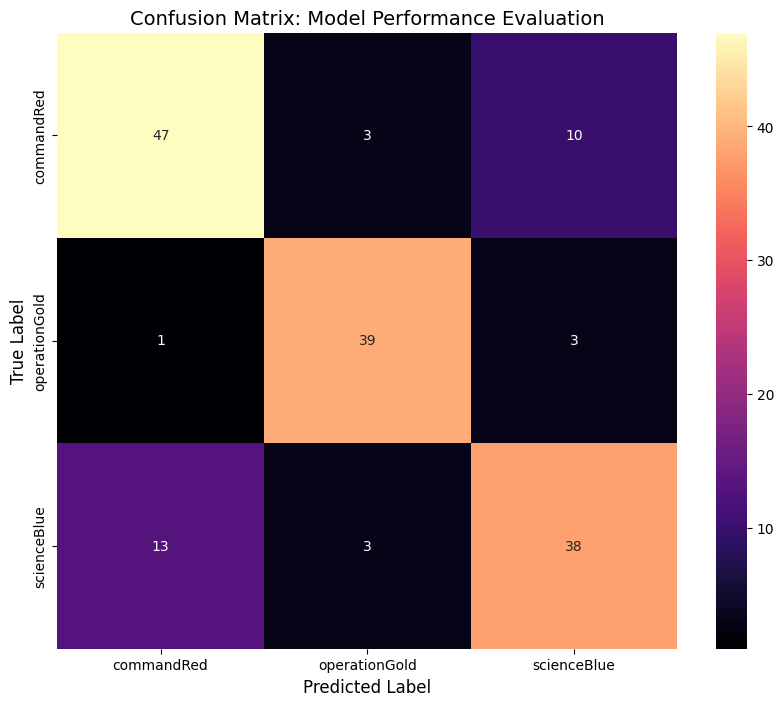


--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

   commandRed       0.77      0.78      0.78        60
operationGold       0.87      0.91      0.89        43
  scienceBlue       0.75      0.70      0.72        54

     accuracy                           0.79       157
    macro avg       0.79      0.80      0.80       157
 weighted avg       0.79      0.79      0.79       157



In [23]:
plot_confusion_matrix(mobilenet_model, val_ds, class_names)

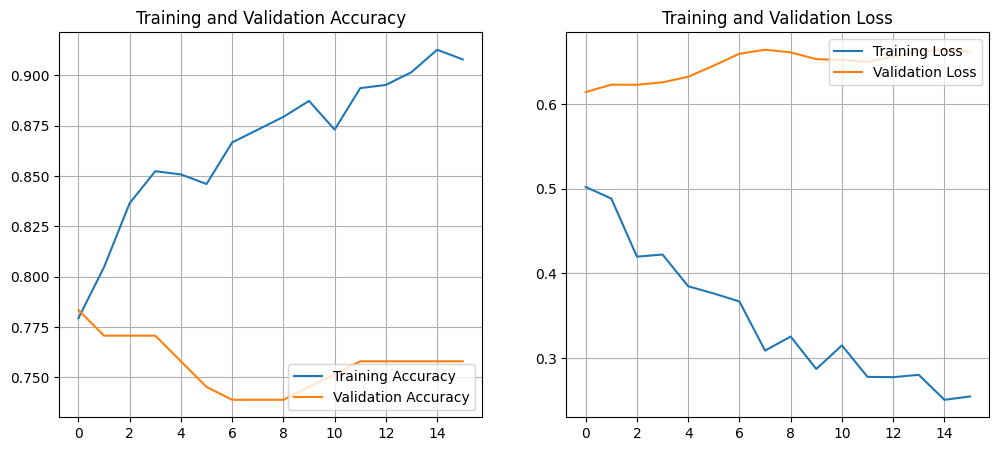

In [24]:
plot_history(history_fine_tune)

## Trying EfficientNetB0

In [25]:
train_ds_raw = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

val_ds_raw = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

Found 787 files belonging to 3 classes.
Using 630 files for training.
Found 787 files belonging to 3 classes.
Using 157 files for validation.


In [26]:
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False
)

# freeze
base_model.trainable = False

In [ ]:

# build model
efficientnet_model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.GaussianNoise(0.1), # random static ot img
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'), # smaller dense layer = less capacity to memorize
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# freeze
base_model.trainable = False

# re compile
efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.F1Score(average='macro')]
)

In [28]:
# training again
history_eff = efficientnet_model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=15,
    class_weight=class_weight,
    callbacks=[early_stop], # early stopping from before
    verbose=1
)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.3492 - f1_score: 0.3249 - loss: 1.2256 - val_accuracy: 0.3503 - val_f1_score: 0.3063 - val_loss: 1.1201
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.3556 - f1_score: 0.3378 - loss: 1.1942 - val_accuracy: 0.3822 - val_f1_score: 0.3440 - val_loss: 1.1107
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.3635 - f1_score: 0.3503 - loss: 1.1703 - val_accuracy: 0.3822 - val_f1_score: 0.3477 - val_loss: 1.1014
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.3476 - f1_score: 0.3274 - loss: 1.1991 - val_accuracy: 0.3885 - val_f1_score: 0.3558 - val_loss: 1.0924
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.3619 - f1_score: 0.3529 - loss: 1.1814 - val_accuracy: 0.3885 - val_f1_score: 0.3560 - val_loss: 1.0837
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.3905 - f1_score: 0.3739 - loss: 1.1435 - val_accuracy: 0.3822 - val_f1_score: 0.351

In [29]:
# unfreeze base model
base_model.trainable = True

fine_tune_at = 188 # freeze everything except the last 50 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# recompile // low learning rate
efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
history_eff_epochs = 15
total_epochs = 20 + history_eff_epochs

history_enb0 = efficientnet_model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=total_epochs,
    class_weight=class_weight,
    callbacks=[early_stop],
    initial_epoch=history_eff.epoch[-1], # start from left off
    verbose=1
)

Epoch 15/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.4302 - loss: 1.1151 - val_accuracy: 0.4968 - val_loss: 1.0022
Epoch 16/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.4302 - loss: 1.1061 - val_accuracy: 0.5096 - val_loss: 0.9937
Epoch 17/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.4762 - loss: 1.0453 - val_accuracy: 0.5223 - val_loss: 0.9840
Epoch 18/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.4317 - loss: 1.0506 - val_accuracy: 0.5414 - val_loss: 0.9734
Epoch 19/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.5175 - loss: 1.0045 - val_accuracy: 0.5478 - val_loss: 0.9622
Epoch 20/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.4635 - loss: 1.0162 - val_accuracy: 0.5732 - val_loss: 0.9498
Epoch 21/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.5032 - loss: 1.0030 - val_accuracy: 0.5605 - val_loss: 0.9370
Epoch 22/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.5175 - loss: 0.9875 - val_acc

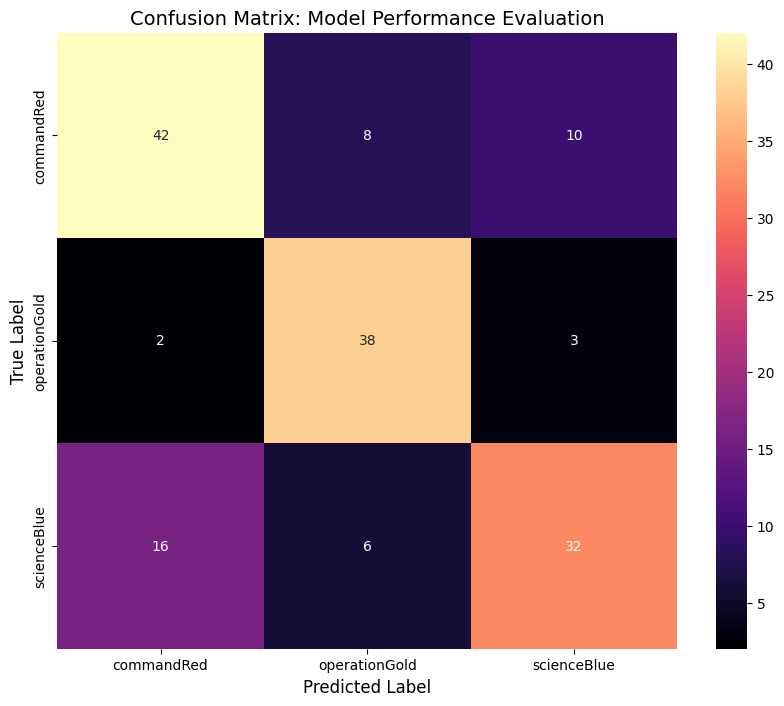


--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

   commandRed       0.70      0.70      0.70        60
operationGold       0.73      0.88      0.80        43
  scienceBlue       0.71      0.59      0.65        54

     accuracy                           0.71       157
    macro avg       0.71      0.73      0.72       157
 weighted avg       0.71      0.71      0.71       157



In [31]:
plot_confusion_matrix(efficientnet_model, val_ds_raw, class_names)

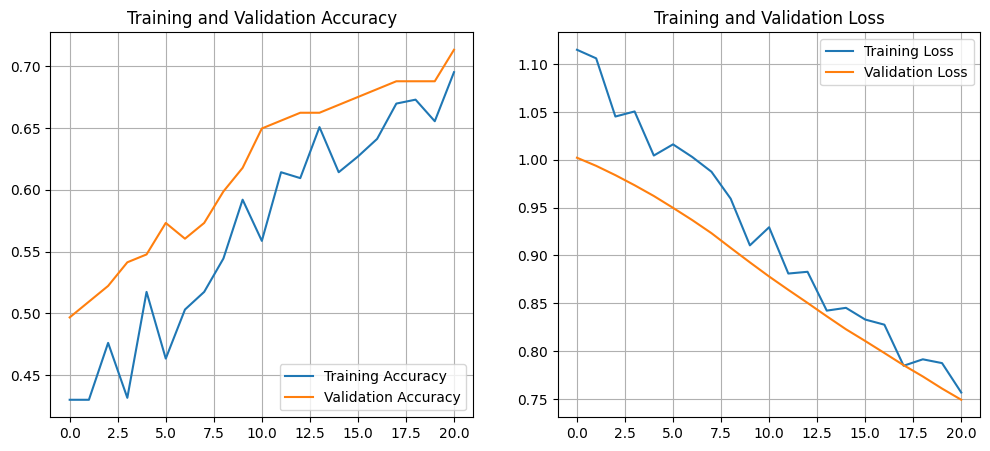

In [32]:
plot_history(history_enb0)

# Validation

---
* Scratch Model
    * accuracy: 0.8921 || 89%
    * loss: 0.2779 || 27%
    * val_accuracy: 0.8981 || 89%
    * val_loss: 0.3372 || 33%
* MobileNetV2
    * accuracy: 0.9063 || 90%
    * loss: 0.2612 || 26%
    * val_accuracy: 0.7580 || 75%
    * val_loss: 0.6910 || 69%
* EfficientNetB0
    * accuracy: 0.7079 || 70%
    * loss: 0.6972 || 69%
    * val_accuracy: 0.7452 || 74%
    * val_loss: 0.6973 || 69%

## K-fold cross validation

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import pandas as pd

all_file_paths = []
all_labels = []

# map cat names to int
label_map = {category: i for i, category in enumerate(categories)}

for category in categories:
    path = data_dir / category
    # get all img files
    files = list(path.glob('*.jpg')) + list(path.glob('*.jpeg')) + list(path.glob('*.png'))
    
    for file_path in files:
        all_file_paths.append(str(file_path))
        all_labels.append(label_map[category])

all_file_paths = np.array(all_file_paths)
all_labels = np.array(all_labels)

# --- MODFEL VALIDATION ---

def run_model_validation(model_name, file_paths, labels, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    file_paths = np.array(file_paths)
    labels = np.array(labels)

    print(f"\n" + "="*50)
    print(f"STARTING K-FOLD: {model_name}")
    print("="*50)

    for fold, (train_idx, val_idx) in enumerate(skf.split(file_paths, labels)):
        keras.backend.clear_session()
        
        # data setup
        def _parse_fn(path, label):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (128, 128))
            if model_name == 'MobileNet':
                img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
            elif model_name == 'Custom':
                img = img / 255.0
            return img, label

        train_ds = tf.data.Dataset.from_tensor_slices((file_paths[train_idx], 
                                                     tf.keras.utils.to_categorical(labels[train_idx], 3)))
        train_ds = train_ds.map(_parse_fn).batch(32).prefetch(tf.data.AUTOTUNE)
        val_ds = tf.data.Dataset.from_tensor_slices((file_paths[val_idx], 
                                                   tf.keras.utils.to_categorical(labels[val_idx], 3)))
        val_ds = val_ds.map(_parse_fn).batch(32).prefetch(tf.data.AUTOTUNE)

        # build model and train
        if model_name == 'Custom':
            model = star_trek_cnn_model() # Calling your specific architecture
            model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model.fit(train_ds, validation_data=val_ds, epochs=30, verbose=0, callbacks=[early_stop])
        else:
            # transfer learning
            if model_name == 'MobileNet':
                model, base_model = build_mobilenet_v2_strict()
                fine_tune_at = 130
            else:
                model, base_model = build_efficientnet_b0_strict()
                fine_tune_at = 188

            # train step 1
            model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=0)
            
            # step 2
            base_model.trainable = True
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
            model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
            
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=0, callbacks=[early_stop])

        eval_metrics = model.evaluate(val_ds, verbose=0)
        
        # error fix for acc name
        metric_names = model.metrics_names
        if 'accuracy' in metric_names:
            idx = metric_names.index('accuracy')
        elif 'acc' in metric_names:
            idx = metric_names.index('acc')
        else:
            idx = 1 
            
        acc = eval_metrics[idx]
        fold_results.append(acc)
        print(f"Fold {fold+1} Accuracy: {acc*100:.2f}%")

    return fold_results

# --- MODELS ARCHITECTURE  ---

def build_mobilenet_v2_strict():
    base_model = keras.applications.MobileNetV2(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
    base_model.trainable = False
    
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    model = keras.Sequential([
        layers.Input(shape=(128, 128, 3)),
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

def build_efficientnet_b0_strict():
    base_model = keras.applications.EfficientNetB0(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
    base_model.trainable = False
    
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    model = keras.Sequential([
        layers.Input(shape=(128, 128, 3)),
        data_augmentation,
        layers.GaussianNoise(0.1),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

# --- RUNNING & REPORT ---
results = {}

results['Custom'] = run_model_validation('Custom', all_file_paths, all_labels)
results['MobileNet'] = run_model_validation('MobileNet', all_file_paths, all_labels)
results['EfficientNet'] = run_model_validation('EfficientNet', all_file_paths, all_labels)

print("\n" + "#"*50)
print("             FINAL SUMMARY REPORT")
print("#"*50)
summary_data = []
for model_name, scores in results.items():
    summary_data.append({
        'Model': model_name,
        'Mean Accuracy': f"{np.mean(scores)*100:.2f}%",
        'Std Dev': f"{np.std(scores)*100:.2f}%"
    })

print(pd.DataFrame(summary_data))